In [1]:
import pandas as pd
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./delta.csv")
data.head()

,Unnamed: 0,TWEET_ID,USER_ID,TWEET,EMOJI,TWEET_SENTIMENT,PROCESSED_TWEET,TARGET_EMOJIS_LIST,nltk_aggregated_score,spacy_aggregated_score,hugging_face_score,emoji_score,delta_nltk,delta_spacy,delta_hugging_face
0,0,683805597976924160,155227972,"@DavidJo52951945 Think your own goverment is ,...",0x1f602,neutral,think goverment stupid fool ask economic sup...,0x1f602,-0.5574,-0.30,0.878392,0.221,0.7784,0.521,0.657392
1,1,683805941414936576,155227972,@DavidJo52951945 Or maybe that has to be calcu...,0x1f608|0x1f602,negative,maybe calculate cost refugee support first uk...,0x1f608|0x1f602,-0.0516,0.25,0.845192,0.243,0.2946,0.007,0.602192
2,2,683879626049888256,374371350,EgencyEnt @yudaichin Welcome ya! 😄,0x1f604,neutral,egencyent welcome ya,0x1f604,0.4588,0.80,-0.674690,0.421,0.0378,0.379,1.095690
3,4,684018933763014656,63925655,@RedHotSquirrel @PoliticsSense\nI'm glad to he...,0x1f600,positive,im glad hear need country control thumbs_up c...,0x1f600,0.4588,0.50,-0.844620,0.568,0.1092,0.068,1.412620
4,5,684077778308730880,4444414572,They found lumbersexuals making a brexit to th...,0x1f631,neutral,find lumbersexuals make brexit share economy d...,0x1f631,0.2960,-0.15,0.663730,0.190,0.1060,0.340,0.473730


In [3]:
data.columns

Index(['Unnamed: 0', 'TWEET_ID', 'USER_ID', 'TWEET', 'EMOJI',
       'TWEET_SENTIMENT', 'PROCESSED_TWEET', 'TARGET_EMOJIS_LIST',
       'nltk_aggregated_score', 'spacy_aggregated_score', 'hugging_face_score',
       'emoji_score', 'delta_nltk', 'delta_spacy', 'delta_hugging_face'],
      dtype='object')

In [4]:
data['delta_nltk']= data['nltk_aggregated_score'] - data['emoji_score'] 
data['delta_spacy']= data['spacy_aggregated_score'] - data['emoji_score']
data['delta_hugging_face']= data['hugging_face_score'] - data['emoji_score']

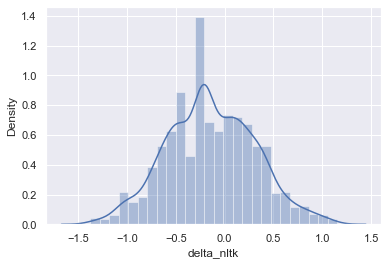

In [5]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.distplot(data['delta_nltk'])

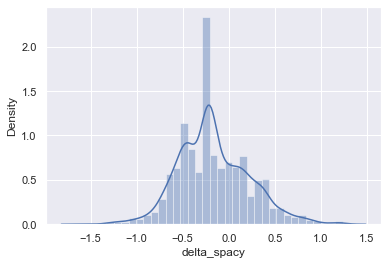

In [6]:
ax = sns.distplot(data['delta_spacy'])

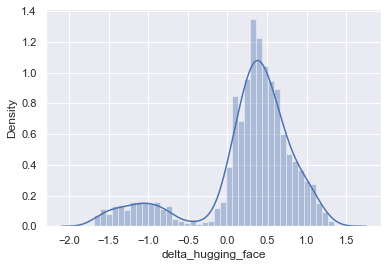

In [7]:
ax = sns.distplot(data['delta_hugging_face'])

In [8]:
#Gamma Calculation
data["gamma_text"] = data["delta_nltk"].map(lambda x: 1 if x > 0 else 0)
data["gamma_emoticon"] = data["emoji_score"].map(lambda x: 1 if x > 0 else 0)

In [9]:
data['gamma'] = data["gamma_text"] & data["gamma_emoticon"]

In [10]:
data['gamma'].value_counts()

0    1576
1     509
Name: gamma, dtype: int64

### What does this mean?
About 75% of the tweets have opposite polarity of that of emoticons. Does that mean all of these tweets are non-conformant? No. We need to consider the magnitude of non-conformance as well. So, need to filter the tweets based on the threshold, do the gamma calculation and then analyse the direction of polarity.  

In [64]:
#Filtering extreme quartiles
filtered_data = data[(data["delta_nltk"] > 0.5) | (data["delta_nltk"] < -0.5)]
print(f"[INFO] #Non-conformant tweets: {len(filtered_data)} [{len(filtered_data)/len(data)}%]")
filtered_data["gamma_text"] = filtered_data["nltk_aggregated_score"].map(lambda x: 1 if x > 0 else 0)
filtered_data["gamma_emoticon"] = filtered_data["emoji_score"].map(lambda x: 1 if x > 0 else 0)
filtered_data['gamma'] = filtered_data['gamma_text']
for index,row in filtered_data.iterrows():
    if row['gamma_text'] == row['gamma_emoticon']:
        row['gamma'] = 1
    else:
        row['gamma'] = 0
filtered_data['gamma'].value_counts()

[INFO] #Non-conformant tweets: 603 [0.2892086330935252%]


0    443
1    160
Name: gamma, dtype: int64

In [52]:
filtered_data_spacy = data[(data["delta_spacy"] > 0.5) | (data["delta_spacy"] < -0.5)]
print(f"[INFO] #Non-conformant tweets: {len(filtered_data_spacy)} [{len(filtered_data_spacy)/len(data)}%]")
filtered_data_spacy["gamma_text"] = filtered_data_spacy["delta_spacy"].map(lambda x: 1 if x > 0 else 0)
filtered_data_spacy["gamma_emoticon"] = filtered_data_spacy["emoji_score"].map(lambda x: 1 if x > 0 else 0)
filtered_data_spacy['gamma'] = filtered_data_spacy['gamma_text']
for index,row in filtered_data_spacy.iterrows():
    if row['gamma_text'] == row['gamma_emoticon']:
        row['gamma'] = 1
    else:
        row['gamma'] = 0
filtered_data_spacy['gamma'].value_counts()

[INFO] #Non-conformant tweets: 459 [0.22014388489208633%]


0    355
1    104
Name: gamma, dtype: int64

In [53]:
filtered_data_hf = data[(data["delta_hugging_face"] > 0.5) | (data["delta_hugging_face"] < -0.5)]
print(f"[INFO] #Non-conformant tweets: {len(filtered_data_hf)} [{len(filtered_data_hf)/len(data)}%]")
filtered_data_hf["gamma_text"] = filtered_data_hf["delta_hugging_face"].map(lambda x: 1 if x > 0 else 0)
filtered_data_hf["gamma_emoticon"] = filtered_data_hf["emoji_score"].map(lambda x: 1 if x > 0 else 0)
filtered_data_hf['gamma'] = filtered_data_hf['gamma_text']
for index,row in filtered_data_hf.iterrows():
    if row['gamma_text'] == row['gamma_emoticon']:
        row['gamma'] = 1
    else:
        row['gamma'] = 0
filtered_data_hf['gamma'].value_counts()

[INFO] #Non-conformant tweets: 1023 [0.4906474820143885%]


1    743
0    280
Name: gamma, dtype: int64

In [54]:
#Descriptive Statistics
from scipy import stats
stats.describe(data['delta_hugging_face'])

DescribeResult(nobs=2085, minmax=(-1.6891747961044312, 1.343540594100952), mean=0.24683462566295578, variance=0.3880277480128961, skewness=-1.3727989209035614, kurtosis=1.461075688716015)

In [55]:
stats.describe(data['delta_nltk'])

DescribeResult(nobs=2085, minmax=(-1.377, 1.153), mean=-0.13962867534543794, variance=0.2029142851156556, skewness=0.06615269995958749, kurtosis=-0.22800866784648166)

In [56]:
stats.describe(data['delta_spacy'])

DescribeResult(nobs=2085, minmax=(-1.568, 1.238), mean=-0.16421555108981967, variance=0.14740019302654314, skewness=0.3792483918060043, kurtosis=0.4593865563127282)

|          | NLTK            | SPACY           | HUGGING FACE |
|----------|-----------------|-----------------|--------------|
| nobs     | 2085            | 2085            | 2085         |
| minmax   | (-1.377, 1.153) | (-1.568, 1.238) |(-1.68, 1.34) |
| mean     | -0.1386         | -0.1642         | 0.2468       |
| variance | 0.2029          | 0.1474          | 0.3880       |
| skewness | 0.0661          | 0.3792          | -1.372       |
| kurtosis | -0.2280         | 0.4593          | 1.461        |

|                                | NLTK      | SPACY     | HUGGING FACE |
|--------------------------------|-----------|-----------|--------------|
| #Filtered Tweets               | 528 (28%) | 409 (22%) | 865 (46%)    |
| #tweets with opposite polarity | 490       | 371       | 706          |

In [57]:
positive_tweets = filtered_data[(filtered_data['gamma_text'] == 1)]
negative_tweets = filtered_data[(filtered_data['gamma_text'] == 0)]

In [58]:
target_emoji_list = [
    '0x1f602', '0x1f60d', '0x1f62d', '0x1f618', '0x1f60a', '0x1f601', '0x1f629', '0x1f64f',
    '0x1f60f', '0x1f609', '0x1f64c', '0x1f648', '0x1f604', '0x1f612', '0x1f603', '0x1f614',
    '0x1f631', '0x1f61c', '0x1f633', '0x1f621', '0x1f60e', '0x1f622', '0x1f60b', '0x1f64a',
    '0x1f634', '0x1f60c', '0x1f61e', '0x1f606', '0x1f61d', '0x1f62a', '0x1f62b', '0x1f605',
    '0x1f600', '0x1f61a', '0x1f63b', '0x1f625', '0x1f615', '0x1f624', '0x1f608', '0x1f630',
    '0x1f611', '0x1f639', '0x1f620', '0x1f613', '0x1f623', '0x1f610', '0x1f628', '0x1f616', 
    '0x1f637', '0x1f64b', '0x1f61b', '0x1f62c', '0x1f619', '0x1f646', '0x1f645', '0x1f649',
    '0x1f607', '0x1f63f', '0x1f632', '0x1f636', '0x1f635', '0x1f638', '0x1f627', '0x1f62e',
    '0x1f63d', '0x1f640', '0x1f647', '0x1f61f', '0x1f62f', '0x1f626', '0x1f64d', '0x1f63a',
    '0x1f63e', '0x1f63c', '0x1f64e', '0x1f617'
]
positive_vector = []
negative_vector = []

for item in target_emoji_list:
    positive_vector.append(0)
    negative_vector.append(0)

In [59]:
for index,tweet in positive_tweets.iterrows():
    emoticons = tweet['TARGET_EMOJIS_LIST']
    emoticons = emoticons.split("|")
    for emoticon in emoticons:
        target_emoticon_index = target_emoji_list.index(emoticon)
        positive_vector[target_emoticon_index]+=1

In [60]:
for index,tweet in negative_tweets.iterrows():
    emoticons = tweet['TARGET_EMOJIS_LIST']
    emoticons = emoticons.split("|")
    for emoticon in emoticons:
        target_emoticon_index = target_emoji_list.index(emoticon)
        negative_vector[target_emoticon_index]+=1

In [61]:
from scipy.spatial import distance
dissimilarity = distance.braycurtis(positive_vector,negative_vector)
print(dissimilarity)

0.7416481069042317


In [62]:
len(positive_tweets)

160

In [63]:
len(negative_tweets)

443

In [24]:
positive_vector = (np.array(positive_vector) / len(positive_tweets)) * 100
negative_vector = (np.array(negative_vector) / len(negative_tweets)) * 100
dissimilarity = distance.braycurtis(positive_vector,negative_vector)
print(dissimilarity)

0.655003976500167


In [42]:
for index,emoti in enumerate(target_emoji_list):
    print(f"{emoti} {positive_vector[index]} {negative_vector[index]}")

0x1f602 45 223
0x1f60d 2 39
0x1f62d 22 10
0x1f618 0 21
0x1f60a 6 44
0x1f601 1 26
0x1f629 18 3
0x1f64f 0 6
0x1f60f 0 10
0x1f609 0 29
0x1f64c 0 24
0x1f648 0 9
0x1f604 0 6
0x1f612 8 1
0x1f603 0 10
0x1f614 2 0
0x1f631 1 25
0x1f61c 0 7
0x1f633 4 2
0x1f621 15 15
0x1f60e 0 7
0x1f622 3 5
0x1f60b 0 3
0x1f64a 0 4
0x1f634 3 2
0x1f60c 0 2
0x1f61e 4 5
0x1f606 0 14
0x1f61d 0 7
0x1f62a 1 0
0x1f62b 3 8
0x1f605 0 7
0x1f600 3 47
0x1f61a 0 1
0x1f63b 0 5
0x1f625 0 0
0x1f615 17 0
0x1f624 3 2
0x1f608 0 5
0x1f630 1 8
0x1f611 1 0
0x1f639 0 1
0x1f620 2 2
0x1f613 1 0
0x1f623 2 1
0x1f610 13 1
0x1f628 1 8
0x1f616 2 0
0x1f637 3 0
0x1f64b 0 1
0x1f61b 0 4
0x1f62c 2 14
0x1f619 0 0
0x1f646 0 1
0x1f645 0 1
0x1f649 0 1
0x1f607 0 3
0x1f63f 4 0
0x1f632 6 2
0x1f636 1 1
0x1f635 0 1
0x1f638 0 0
0x1f627 1 0
0x1f62e 1 3
0x1f63d 0 3
0x1f640 0 1
0x1f647 0 0
0x1f61f 1 1
0x1f62f 0 0
0x1f626 2 0
0x1f64d 0 0
0x1f63a 0 0
0x1f63e 0 0
0x1f63c 1 0
0x1f64e 0 0
0x1f617 0 0


In [26]:
from scipy import spatial
result = 1 - spatial.distance.cosine(positive_vector, negative_vector)

In [66]:
filtered_data.to_csv("input_sarcasm_model.csv")